In [3]:
import os
import numpy as np
import pandas as pd
import dataset as d
import parameters as p
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import dataset as d
%matplotlib inline

In [4]:
result_dir = 'out'
level_1 = d.data_path.copy()
level_1.pop('cmc')
level_1.pop('facebook')
level_1.pop('ml100k')
level_1.pop('spam')
level_1 = list(level_1.keys())

level_2 = p.prm.copy()
level_2 = list(level_2.keys())

In [5]:
level_1, level_2

(['blood', 'bcw', 'ccrf', 'diabetic', 'google_reviews', 'frogs', 'mm', 'ml1m'],
 ['knn', 'kdtree', 'annoy', 'hnsw'])

In [6]:
cols_dbscore = ['algorithm', 'max_k', 'k', 'n_clusters', 'kmeans_gmm_db_score', 'opf_gmm_db_score', 'random_gmm_db_score']
cols_time = ['algorithm', 'max_k', 'k', 'n_clusters', 'kmeans_init_time', 'opf_init_time', 'random_init_time']

In [7]:
filtered_cols = ['max_k', 'n_clusters','kmeans_gmm_db_score', 'opf_gmm_db_score', 'kmeans_init_time', 'opf_init_time']

In [8]:
h_index = pd.MultiIndex.from_product([level_1, level_2], names=('Dataset', 'Search algorithm'))

### Statistics regarding DB-index scores

In [70]:
df_db = pd.DataFrame(columns=['$k_{max}$', '\# clusters','$k$-means', 'Proposed'], index=h_index)
df_time = pd.DataFrame(columns=['$k_{max}$', '$k$-means', 'Proposed'], index=h_index)

alpha = 0.05

for ds in level_1:
    
    print('Dataset:', ds)
    df_dataset = pd.DataFrame()
    
    for f in os.scandir('/'.join([result_dir, ds])):
        out_file = pd.read_csv(f.path, index_col=0, engine='c', dtype=object)
        df_dataset = pd.concat([df_dataset, out_file], ignore_index=True)
    
    for sa in level_2:

        tmp_df = df_dataset[df_dataset['algorithm'] == f'opf_{sa}'][filtered_cols].astype(float)

        # compare samples statistically with Wilcoxon signed-rank test
        stat, p = wilcoxon(tmp_df['kmeans_gmm_db_score'], tmp_df['opf_gmm_db_score'])

#         print(f'statistic = {stat:.2f}\np-value = {p:.6f}')

        gc = str(round(tmp_df['kmeans_gmm_db_score'].mean(), 4)) + ' \pm ' + str(round(tmp_df['kmeans_gmm_db_score'].std(), 2))
        gt = str(round(tmp_df['opf_gmm_db_score'].mean(), 4)) + ' \pm ' + str(round(tmp_df['opf_gmm_db_score'].std(), 2))

        # Fail to reject H0 (samples have the same distribution)
        if p > alpha:
#             print('Fail to reject H0 (samples have the same distribution')
            gc = '$' + gc + '$'
            gt = '$' + gt + '$'
        else:
        #     print('Reject H0 (samples come from different distributions)')
            if tmp_df['kmeans_gmm_db_score'].mean() < tmp_df['opf_gmm_db_score'].mean():
                gc = '$\mathbf{' + gc + '}$'
                gt = '$' + gt + '$'
            else:
                gt = '$\mathbf{' + gt + '}$'
                gc = '$' + gc + '$'

        k_max = '$' + str(round(tmp_df['max_k'].mean(), 4)) + ' \pm ' + str(round(tmp_df['max_k'].std(), 2)) + '$'
        nc = '$' + str(round(tmp_df['n_clusters'].mean(), 4)) + ' \pm ' + str(round(tmp_df['n_clusters'].std(), 2)) + '$'

        df_db.loc[(ds,sa)] = [k_max, nc, gc, gt]

# Saving statistics to csv file
df_db.to_csv('tables/statistics_db_index.csv')

Dataset: blood
Dataset: bcw
Dataset: ccrf
Dataset: diabetic
Dataset: google_reviews
Dataset: frogs
Dataset: mm
Dataset: ml1m


### Statistics regarding computation cost (running time)

In [58]:
df_db = pd.DataFrame(columns=['$k_{max}$', '\# clusters','$k$-means', 'Proposed'], index=h_index)
df_time = pd.DataFrame(columns=['$k_{max}$', '$k$-means', 'Proposed'], index=h_index)

alpha = 0.05

for ds in level_1:
      
    print('Dataset:', ds)
    df_dataset = pd.DataFrame()
    
    for f in os.scandir('/'.join([result_dir, ds])):
    #     if f.name.find('nov-25-2021') > -1 or f.name.find('nov-26-2021') > -1:
#         print(f.name)
        out_file = pd.read_csv(f.path, index_col=0, engine='c', dtype=object)
        df_dataset = pd.concat([df_dataset, out_file], ignore_index=True)
    
    for sa in level_2:

        tmp_df = df_dataset[df_dataset['algorithm'] == f'opf_{sa}'][filtered_cols].astype(float)

        # compare samples statistically with Wilcoxon signed-rank test
        stat, p = wilcoxon(tmp_df['kmeans_init_time'], tmp_df['opf_init_time'])

#         print(f'statistic = {stat:.2f}\np-value = {p:.6f}')

        gc = str(round(tmp_df['kmeans_init_time'].mean(), 4)) + ' \pm ' + str(round(tmp_df['kmeans_init_time'].std(), 2))
        gt = str(round(tmp_df['opf_init_time'].mean(), 4)) + ' \pm ' + str(round(tmp_df['opf_init_time'].std(), 2))

        # Fail to reject H0 (samples have the same distribution)
        if p > alpha:
#             print('Fail to reject H0 (samples have the same distribution')
            gc = '$' + gc + '$'
            gt = '$' + gt + '$'
        else:
        #     print('Reject H0 (samples come from different distributions)')
            if tmp_df['kmeans_init_time'].mean() < tmp_df['opf_init_time'].mean():
                gc = '$\mathbf{' + gc + '}$'
                gt = '$' + gt + '$'
            else:
                gt = '$\mathbf{' + gt + '}$'
                gc = '$' + gc + '$'

        k_max = '$' + str(round(tmp_df['max_k'].mean(), 4)) + ' \pm ' + str(round(tmp_df['max_k'].std(), 2)) + '$'
        nc = '$' + str(round(tmp_df['n_clusters'].mean(), 4)) + ' \pm ' + str(round(tmp_df['n_clusters'].std(), 2)) + '$'

        df_db.loc[(ds,sa)] = [k_max, nc, gc, gt]

# Saving statistics to csv file
df_db.to_csv('tables/statistics_init_time.csv')

Dataset: blood
Dataset: bcw
Dataset: ccrf
Dataset: diabetic
Dataset: google_reviews
Dataset: frogs
Dataset: mm
Dataset: ml1m


In [59]:
df_db

$k_{max}$         \# clusters  \
Dataset        Search algorithm                                         
blood          knn               $22.2 \pm 20.31$    $49.6 \pm 43.63$   
               kdtree            $22.2 \pm 20.31$    $50.0 \pm 44.05$   
               annoy             $22.2 \pm 20.31$     $49.4 \pm 43.4$   
               hnsw              $22.2 \pm 20.31$     $41.5 \pm 37.1$   
bcw            knn               $27.6 \pm 10.07$     $11.6 \pm 4.84$   
               kdtree            $27.6 \pm 10.07$     $11.6 \pm 4.84$   
               annoy             $27.6 \pm 10.07$     $10.8 \pm 4.52$   
               hnsw              $27.6 \pm 10.07$     $11.5 \pm 4.86$   
ccrf           knn                $10.4 \pm 9.38$   $103.7 \pm 55.54$   
               kdtree             $10.4 \pm 9.38$   $103.8 \pm 55.38$   
               annoy              $10.4 \pm 9.38$   $101.0 \pm 55.23$   
               hnsw               $10.4 \pm 9.38$    $80.5 \pm 40.69$   
diabetic       knn                $21.0 \pm 11.2$    $55.0 \pm 65.76$   
               kdtree             $21.0 \pm 11.2$    $55.0 \pm 65.76$   
               annoy              $21.0 \pm 11.2$    $54.2 \pm 63.75$   
               hnsw               $21.0 \pm 11.2$    $41.1 \pm 47.43$   
google_reviews knn                  $5.0 \pm 0.0$  $1089.7 \pm 15.17$   
               kdtree               $5.0 \pm 0.0$  $1089.7 \pm 15.17$   
               annoy                $5.0 \pm 0.0$  $1100.4 \pm 15.56$   
               hnsw                 $5.0 \pm 0.0$  $1082.2 \pm 17.18$   
frogs          knn               $23.0 \pm 16.41$  $641.9 \pm 654.31$   
               kdtree            $23.0 \pm 16.41$  $641.9 \pm 654.31$   
               annoy             $23.0 \pm 16.41$  $609.3 \pm 622.61$   
               hnsw              $23.0 \pm 16.41$  $612.1 \pm 622.56$   
mm             knn               $21.0 \pm 17.61$    $86.1 \pm 71.47$   
               kdtree            $21.0 \pm 17.61$    $86.5 \pm 71.92$   
               annoy             $21.0 \pm 17.61$    $85.8 \pm 71.66$   
               hnsw              $21.0 \pm 17.61$    $67.8 \pm 58.35$   
ml1m           knn               $39.4 \pm 13.23$   $493.5 \pm 696.0$   
               kdtree            $39.4 \pm 13.23$   $493.5 \pm 696.0$   
               annoy             $39.4 \pm 13.23$  $419.1 \pm 604.66$   
               hnsw              $39.4 \pm 13.23$  $496.0 \pm 694.43$   

                                                  $k$-means  \
Dataset        Search algorithm                               
blood          knn               $\mathbf{0.1173 \pm 0.04}$   
               kdtree            $\mathbf{0.0899 \pm 0.04}$   
               annoy             $\mathbf{0.0895 \pm 0.03}$   
               hnsw              $\mathbf{0.0968 \pm 0.03}$   
bcw            knn               $\mathbf{0.1257 \pm 0.03}$   
               kdtree            $\mathbf{0.0937 \pm 0.03}$   
               annoy             $\mathbf{0.0965 \pm 0.03}$   
               hnsw              $\mathbf{0.0995 \pm 0.02}$   
ccrf           knn               $\mathbf{0.1904 \pm 0.05}$   
               kdtree            $\mathbf{0.1944 \pm 0.09}$   
               annoy             $\mathbf{0.2214 \pm 0.15}$   
               hnsw              $\mathbf{0.1485 \pm 0.03}$   
diabetic       knn               $\mathbf{0.1701 \pm 0.05}$   
               kdtree            $\mathbf{0.1388 \pm 0.02}$   
               annoy             $\mathbf{0.1407 \pm 0.03}$   
               hnsw              $\mathbf{0.1566 \pm 0.06}$   
google_reviews knn               $\mathbf{1.0321 \pm 0.68}$   
               kdtree            $\mathbf{0.8767 \pm 0.52}$   
               annoy             $\mathbf{0.7832 \pm 0.07}$   
               hnsw               $\mathbf{0.758 \pm 0.14}$   
frogs          knn               $\mathbf{0.6572 \pm 0.48}$   
               kdtree            $\mathbf{0.7575 \pm 0.54}$   
               annoy             $\mathbf{0.5

### Generating figure regarding OPF and OPF$_{k-ann}$ evaluation

In [9]:
dataset_names = {
    'blood': 'blood'.capitalize(),
    'bcw': 'bcw'.upper(),
    'ccrf': 'ccrf'.upper(),
    'diabetic': 'diabetic'.capitalize(),
    'google_reviews': 'gr'.upper(),
    'frogs': 'frogs'.capitalize(),
    'ml1m': 'ml1m'.upper(),
    'mm': 'mm'.upper()
}

cols = ['algorithm', 'max_k', 'k', 'n_clusters', 'opf_gmm_db_score']

df_figures = pd.DataFrame()

for ds in level_1:
      
    print('Dataset:', dataset_names.get(ds))
    df_dataset = pd.DataFrame(columns=['Dataset'])
    
    for f in os.scandir('/'.join([result_dir, ds])):

        out_file = pd.read_csv(f.path, index_col=0, engine='c', dtype=object)
        df_dataset = pd.concat([df_dataset, out_file[cols]], ignore_index=True)
    
    df_dataset.fillna(dataset_names.get(ds), inplace=True)
    df_figures = pd.concat([df_figures, df_dataset], ignore_index=True)

Dataset: Blood
Dataset: BCW
Dataset: CCRF
Dataset: Diabetic
Dataset: GR
Dataset: Frogs
Dataset: MM
Dataset: ML1M


In [32]:
dataset_names = {
    'blood': 'blood'.capitalize(),
    'bcw': 'bcw'.upper(),
    'ccrf': 'ccrf'.upper(),
    'diabetic': 'diabetic'.capitalize(),
    'google_reviews': 'gr'.upper(),
    'frogs': 'frogs'.capitalize(),
    'ml1m': 'ml1m'.upper(),
    'mm': 'mm'.upper()
}

cols = ['algorithm', 'max_k', 'k', 'n_clusters', 'opf_gmm_db_score', 'opf_init_time']

df_figures = pd.DataFrame()

for ds in level_1:
      
    print('Dataset:', dataset_names.get(ds))
    df_dataset = pd.DataFrame(columns=['Dataset'])
    
    for f in os.scandir('/'.join([result_dir, ds])):

        out_file = pd.read_csv(f.path, index_col=0, engine='c', dtype=object)
        df_dataset = pd.concat([df_dataset, out_file[cols]], ignore_index=True)
    
    df_dataset.fillna(dataset_names.get(ds), inplace=True)
    df_figures = pd.concat([df_figures, df_dataset], ignore_index=True)

Dataset: Blood
Dataset: BCW
Dataset: CCRF
Dataset: Diabetic
Dataset: GR
Dataset: Frogs
Dataset: MM
Dataset: ML1M


In [33]:
dict_types = {
    'algorithm': 'str',
    'max_k': 'int32', 
    'k': 'int32', 
    'n_clusters': 'int32',
    'opf_gmm_db_score': 'float32',
    'opf_init_time': 'float32'}

In [34]:
df_figures = df_figures.astype(dict_types, copy=False)
df_figures[['algorithm']] = df_figures[['algorithm']].applymap(lambda x: x[4:])

In [35]:
df = df_figures[['Dataset', 'algorithm','opf_gmm_db_score', 'opf_init_time']]
df

,Dataset,algorithm,opf_gmm_db_score,opf_init_time
0,Blood,knn,1.613101,36.594276
1,Blood,kdtree,1.613101,21.623400
2,Blood,annoy,1.530637,25.679193
3,Blood,hnsw,1.530637,27.677435
4,Blood,knn,1.573046,6.298537
...,...,...,...,...
315,ML1M,hnsw,1.273341,35.435318
316,ML1M,knn,1.172392,93.151115
317,ML1M,kdtree,1.172392,28.734066
318,ML1M,annoy,1.151722,26.708277


In [139]:
for dataset in dataset_names.values():

    print(dataset)

    df_dataset = df_figures[['Dataset', 'algorithm','opf_gmm_db_score']]
    df_dataset[df_dataset['Dataset'] == dataset]

    knn = df_dataset[df_dataset['Dataset'] == dataset].query("algorithm == 'knn'")['opf_gmm_db_score']
    knn.name = 'knn'
    kdtree = df_dataset[df_dataset['Dataset'] == dataset].query("algorithm == 'kdtree'")['opf_gmm_db_score']
    kdtree.name = 'kdtree'
    annoy = df_dataset[df_dataset['Dataset'] == dataset].query("algorithm == 'annoy'")['opf_gmm_db_score']
    annoy.name = 'annoy'
    hnsw = df_dataset[df_dataset['Dataset'] == dataset].query("algorithm == 'hnsw'")['opf_gmm_db_score']
    hnsw.name = 'hnsw'

    alpha = 0.05

    for proposed in [kdtree, annoy, hnsw]:

        # compare samples statistically with Wilcoxon signed-rank test
        stat, p = wilcoxon(knn, proposed, zero_method='zsplit')

        # Fail to reject H0 (samples come from the same distribution)
        if p > alpha:
            print(proposed.name, '- Groups are statistically similar.')
        else:
            print(proposed.name, '- Groups are statistically dissimilar.')
        
    print('\n')

Blood
kdtree - Groups are statistically similar.


annoy - Groups are statistically similar.


hnsw - Groups are statistically similar.


BCW
kdtree - Groups are statistically similar.


annoy - Groups are statistically similar.


hnsw - Groups are statistically similar.


CCRF
kdtree - Groups are statistically similar.


annoy - Groups are statistically similar.


hnsw - Groups are statistically dissimilar.


Diabetic
kdtree - Groups are statistically similar.


annoy - Groups are statistically similar.


hnsw - Groups are statistically similar.


GR
kdtree - Groups are statistically similar.


annoy - Groups are statistically similar.


hnsw - Groups are statistically dissimilar.


Frogs
kdtree - Groups are statistically similar.


annoy - Groups are statistically similar.


hnsw - Groups are statistically similar.


ML1M
kdtree - Groups are statistically similar.


annoy - Groups are statistically similar.


hnsw - Groups are statistically similar.


MM
kdtree - Groups are statistic

In [136]:
from scipy.stats import kruskal, friedmanchisquare
    
for dataset in dataset_names.values():

    print(dataset)

    df_dataset = df_figures[['Dataset', 'algorithm','opf_gmm_db_score']]
    df_dataset[df_dataset['Dataset'] == dataset]

    knn = df_dataset[df_dataset['Dataset'] == dataset].query("algorithm == 'knn'")['opf_gmm_db_score']
    knn.name = 'knn'
    kdtree = df_dataset[df_dataset['Dataset'] == dataset].query("algorithm == 'kdtree'")['opf_gmm_db_score']
    kdtree.name = 'kdtree'
    annoy = df_dataset[df_dataset['Dataset'] == dataset].query("algorithm == 'annoy'")['opf_gmm_db_score']
    annoy.name = 'annoy'
    hnsw = df_dataset[df_dataset['Dataset'] == dataset].query("algorithm == 'hnsw'")['opf_gmm_db_score']
    hnsw.name = 'hnsw'

    alpha = 0.05
    stat, p = friedmanchisquare(knn, kdtree, annoy, hnsw)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

Blood
Statistics=0.929, p=0.819
Same distributions (fail to reject H0)
BCW
Statistics=3.105, p=0.376
Same distributions (fail to reject H0)
CCRF
Statistics=7.387, p=0.061
Same distributions (fail to reject H0)
Diabetic
Statistics=5.467, p=0.141
Same distributions (fail to reject H0)
GR
Statistics=10.000, p=0.019
Different distributions (reject H0)
Frogs
Statistics=13.600, p=0.004
Different distributions (reject H0)
ML1M
Statistics=6.533, p=0.088
Same distributions (fail to reject H0)
MM
Statistics=0.000, p=1.000
Same distributions (fail to reject H0)


In [64]:
mean_df = df.groupby(['Dataset', 'algorithm'], sort=False).mean()[['opf_gmm_db_score']]
std_df = df.groupby(['Dataset', 'algorithm'], sort=False).std()[['opf_gmm_db_score']]
mean_std_df = pd.concat([mean_df, std_df], axis=1)
mean_std_df.columns = ['mean', 'std']


mean       std
Dataset  algorithm                    
Blood    knn        1.341063  0.337676
         kdtree     1.345987  0.342895
         annoy      1.351046  0.328910
         hnsw       1.331109  0.201095
BCW      knn        0.728291  0.173687
         kdtree     0.728291  0.173687
         annoy      0.720794  0.181743
         hnsw       0.710061  0.155154
CCRF     knn        1.213203  0.155722
         kdtree     1.225317  0.152044
         annoy      1.272854  0.191108
         hnsw       1.129409  0.143155
Diabetic knn        1.539440  0.221445
         kdtree     1.539440  0.221445
         annoy      1.477664  0.181043
         hnsw       1.427121  0.158594
GR       knn        0.837422  0.009593
         kdtree     0.837422  0.009593
         annoy      0.831324  0.012856
         hnsw       0.824523  0.012120
Frogs    knn        1.249812  0.105332
         kdtree     1.249812  0.105332
         annoy      1.269710  0.106431
         hnsw       1.216429  0.106736
MM       knn        1.842821  0.884184
         kdtree     2.208460  1.578633
         annoy      1.969943  0.972873
         hnsw       1.533472  0.247582
ML1M     knn        1.262693  0.149804
         kdtree     1.262693  0.149804
         annoy      1.320420  0.156573
         hnsw       1.242427  0.134183

In [63]:
def to_mean_std(row):
    return '$' + str(row['mean'].round(4)) + ' \pm ' + str(row['std'].round(2)) + '$'

In [65]:
mean_std_df['mean_std'] = mean_std_df.apply(lambda row: to_mean_std(row), axis=1)

In [88]:
df_tex = pd.DataFrame(index=list(dataset_names.values()), columns=['knn', 'kdtree', 'annoy', 'hnsw'])

for ds in dataset_names.values():
    tmp = mean_std_df.loc[(ds)].T.loc[['mean_std']]
    df_tex.loc[ds] = tmp.loc['mean_std'].values

df_tex.to_csv('tables/db_index_opfs.csv')

In [87]:
df_tex

,knn,kdtree,annoy,hnsw
Blood,$1.3411 \pm 0.34$,$1.346 \pm 0.34$,$1.351 \pm 0.33$,$1.3311 \pm 0.2$
BCW,$0.7283 \pm 0.17$,$0.7283 \pm 0.17$,$0.7208 \pm 0.18$,$0.7101 \pm 0.16$
CCRF,$1.2132 \pm 0.16$,$1.2253 \pm 0.15$,$1.2729 \pm 0.19$,$1.1294 \pm 0.14$
Diabetic,$1.5394 \pm 0.22$,$1.5394 \pm 0.22$,$1.4777 \pm 0.18$,$1.4271 \pm 0.16$
GR,$0.8374 \pm 0.01$,$0.8374 \pm 0.01$,$0.8313 \pm 0.01$,$0.8245 \pm 0.01$
Frogs,$1.2498 \pm 0.11$,$1.2498 \pm 0.11$,$1.2697 \pm 0.11$,$1.2164 \pm 0.11$
ML1M,$1.2627 \pm 0.15$,$1.2627 \pm 0.15$,$1.3204 \pm 0.16$,$1.2424 \pm 0.13$
MM,$1.8428 \pm 0.88$,$2.2085 \pm 1.58$,$1.9699 \pm 0.97$,$1.5335 \pm 0.25$


In [53]:
mean_df.loc[('BCW')].T.loc[['opf_gmm_db_score']]

algorithm,knn,kdtree,annoy,hnsw
opf_gmm_db_score,0.728291,0.728291,0.720794,0.710061


In [37]:
def format_search_alg(row):
    
    alg = row['algorithm']
    
    if alg  == 'knn':
        return '$k$-nn'
    
    if alg == 'kdtree':
        return 'KD-Tree'
    
    if alg == 'annoy':
        return 'ANNOY'
    else:
        return 'HNSW'

In [38]:
df_fig = df_figures.copy()

In [39]:
df_fig['algorithm'] = df_fig.apply(lambda row: format_search_alg(row), axis=1)

In [41]:
df_fig

,Dataset,algorithm,max_k,k,n_clusters,opf_gmm_db_score,opf_init_time
0,Blood,$k$-nn,47,45,3,1.613101,36.594276
1,Blood,KD-Tree,47,45,3,1.613101,21.623400
2,Blood,ANNOY,47,46,3,1.530637,25.679193
3,Blood,HNSW,47,47,3,1.530637,27.677435
4,Blood,$k$-nn,15,15,21,1.573046,6.298537
...,...,...,...,...,...,...,...
315,ML1M,HNSW,49,49,246,1.273341,35.435318
316,ML1M,$k$-nn,49,49,216,1.172392,93.151115
317,ML1M,KD-Tree,49,49,216,1.172392,28.734066
318,ML1M,ANNOY,49,49,172,1.151722,26.708277


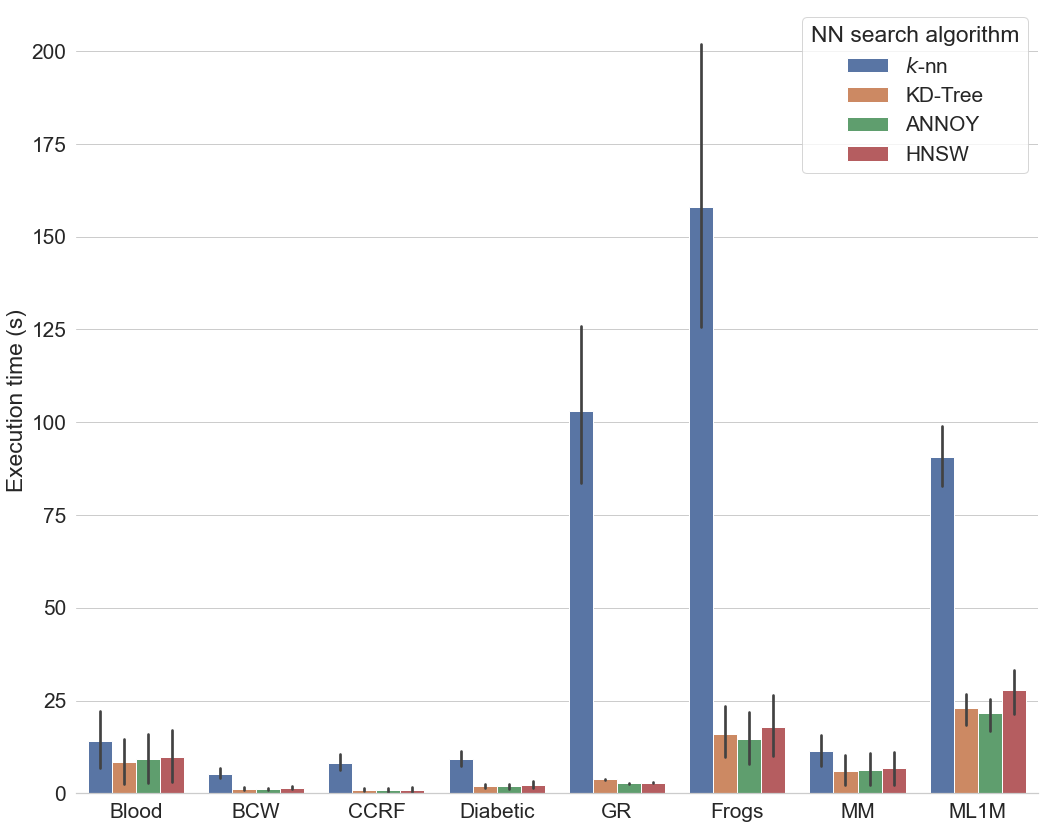

In [54]:
sns.set_theme(style='whitegrid', font_scale=1.9)
g = sns.catplot(data=df_fig, 
                kind='bar', 
                x='Dataset', 
                y='opf_init_time', 
                hue='algorithm', 
                height=10, legend_out=False)
g.set_axis_labels('', 'Execution time (s)')
# g.set_xticklabels(rotation=40)
# g.set(yscale='log')
g.despine(left=True)
plt.gcf().set_size_inches(15, 12)
plt.tight_layout()
plt.legend(loc='upper right', title='NN search algorithm')
plt.savefig('tables/opfs_time_comparison.pdf', format='pdf', bbox_inches='tight', dpi=200)

In [151]:
df_figures

,Dataset,algorithm,max_k,k,n_clusters,opf_gmm_db_score,opf_init_time
0,Blood,knn,47,45,3,1.613101,36.594276
1,Blood,kdtree,47,45,3,1.613101,21.623400
2,Blood,annoy,47,46,3,1.530637,25.679193
3,Blood,hnsw,47,47,3,1.530637,27.677435
4,Blood,knn,15,15,21,1.573046,6.298537
...,...,...,...,...,...,...,...
315,ML1M,hnsw,49,49,246,1.273341,35.435318
316,ML1M,knn,49,49,216,1.172392,93.151115
317,ML1M,kdtree,49,49,216,1.172392,28.734066
318,ML1M,annoy,49,49,172,1.151722,26.708277
